In [4]:
import pandas as pd
import numpy as np

<div dir="rtl" style=" font-size: 20px;">
>>> استخراج فایل CSV داده‌ها
</div>

In [2]:
import requests
from datetime import datetime, timedelta

# end_date = datetime.today().date()
# start_date = end_date - timedelta(days=30)

url = "https://earthquake.usgs.gov/fdsnws/event/1/query"
params = {
    "format": "csv",
    "starttime": "2025-9-15",
    "endtime": "2025-10-15",
    "minlatitude": 24,
    "maxlatitude": 46,
    "minlongitude": 123,
    "maxlongitude": 146,
    "minmagnitude": 0
}
response = requests.get(url, params=params)
with open("japan_earthquakes.csv", "w", encoding="utf-8") as f:
        f.write(response.text)


<div dir="rtl" style=" font-size: 20px;">
>>> خواندن فایل سیو شده در سیستم</div>

In [5]:
df = pd.read_csv("japan_earthquakes.csv")
df.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2025-10-14T23:29:10.333Z,30.3762,138.2748,440.542,4.5,mb,59,99,3.029,0.41,...,2025-10-15T00:42:51.040Z,"Izu Islands, Japan region",earthquake,11.38,7.633,0.034,261,reviewed,us,us
1,2025-10-14T03:34:24.223Z,39.6050,139.5058,11.325,4.6,mb,59,126,1.681,0.77,...,2025-10-14T05:34:11.866Z,"51 km SW of Tennō, Japan",earthquake,7.48,4.275,0.080,47,reviewed,us,us
2,2025-10-13T03:25:44.134Z,38.5931,142.5944,38.354,4.7,mb,39,146,2.491,0.93,...,2025-10-16T12:09:20.916Z,"92 km SE of Ōfunato, Japan",earthquake,8.05,7.918,0.087,40,reviewed,us,us
3,2025-10-11T03:22:00.952Z,30.3456,138.4539,432.857,4.8,mb,71,49,2.994,0.63,...,2025-10-11T03:38:55.040Z,"Izu Islands, Japan region",earthquake,8.96,6.664,0.028,385,reviewed,us,us
4,2025-10-10T22:06:36.054Z,41.7258,142.6790,58.696,4.3,mb,35,164,0.459,1.12,...,2025-10-10T22:34:36.040Z,"48 km S of Urakawa, Japan",earthquake,7.90,9.880,0.119,20,reviewed,us,us


<div dir="rtl" style=" font-size: 20px;">
>>> حذف 3 ستون بدردنخور</div>

In [7]:
df = df.drop(columns=["status","locationSource", "magSource"])

<div dir="rtl" style=" font-size: 20px;">
>>> تبدیل داده‌های زمانی به تایم‌آبجکت ( اینجا میشد از متدهای خود پانداس هم استفاده کرد)
</div>

In [6]:
import datetime

def date_objector(string):
    return datetime.datetime.strptime(string, "%Y-%m-%dT%H:%M:%S.%fZ")
df["time"] = df["time"].apply(date_objector)
df["updated"] = df["updated"].apply(date_objector)
# df["time"] = pd.to_datetime(df["time"])
# df["updated"] = pd.to_datetime(df["updated"])
df.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2025-10-14 23:29:10.333,30.3762,138.2748,440.542,4.5,mb,59,99,3.029,0.41,...,2025-10-15 00:42:51.040,"Izu Islands, Japan region",earthquake,11.38,7.633,0.034,261,reviewed,us,us
1,2025-10-14 03:34:24.223,39.6050,139.5058,11.325,4.6,mb,59,126,1.681,0.77,...,2025-10-14 05:34:11.866,"51 km SW of Tennō, Japan",earthquake,7.48,4.275,0.080,47,reviewed,us,us
2,2025-10-13 03:25:44.134,38.5931,142.5944,38.354,4.7,mb,39,146,2.491,0.93,...,2025-10-16 12:09:20.916,"92 km SE of Ōfunato, Japan",earthquake,8.05,7.918,0.087,40,reviewed,us,us
3,2025-10-11 03:22:00.952,30.3456,138.4539,432.857,4.8,mb,71,49,2.994,0.63,...,2025-10-11 03:38:55.040,"Izu Islands, Japan region",earthquake,8.96,6.664,0.028,385,reviewed,us,us
4,2025-10-10 22:06:36.054,41.7258,142.6790,58.696,4.3,mb,35,164,0.459,1.12,...,2025-10-10 22:34:36.040,"48 km S of Urakawa, Japan",earthquake,7.90,9.880,0.119,20,reviewed,us,us


<div dir="rtl" style=" font-size: 20px;">
>>> تعداد ردیف و ستون
</div>

In [8]:
print("تعداد ردیف: ", df.shape[0])
print("تعداد ستون: ", df.shape[1])


تعداد ردیف:  45
تعداد ستون:  19


<div dir="rtl" style=" font-size: 20px;">
>>> دیتاتایپ ستون‌ها
</div>

In [9]:
df.dtypes

time               datetime64[ns]
latitude                  float64
longitude                 float64
depth                     float64
mag                       float64
magType                    object
nst                         int64
gap                         int64
dmin                      float64
rms                       float64
net                        object
id                         object
updated            datetime64[ns]
place                      object
type                       object
horizontalError           float64
depthError                float64
magError                  float64
magNst                      int64
dtype: object

<div dir="rtl" style=" font-size: 20px;">
>>> تبدیل تمام مقادیر عددی به float
</div>


In [10]:
num_cols = df.select_dtypes(include=["number"]).columns
df[num_cols] = df[num_cols].astype(float)
df.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,net,id,updated,place,type,horizontalError,depthError,magError,magNst
0,2025-10-14 23:29:10.333,30.3762,138.2748,440.542,4.5,mb,59.0,99.0,3.029,0.41,us,us6000rh76,2025-10-15 00:42:51.040,"Izu Islands, Japan region",earthquake,11.38,7.633,0.034,261.0
1,2025-10-14 03:34:24.223,39.6050,139.5058,11.325,4.6,mb,59.0,126.0,1.681,0.77,us,us6000rgzf,2025-10-14 05:34:11.866,"51 km SW of Tennō, Japan",earthquake,7.48,4.275,0.080,47.0
2,2025-10-13 03:25:44.134,38.5931,142.5944,38.354,4.7,mb,39.0,146.0,2.491,0.93,us,us6000rgtf,2025-10-16 12:09:20.916,"92 km SE of Ōfunato, Japan",earthquake,8.05,7.918,0.087,40.0
3,2025-10-11 03:22:00.952,30.3456,138.4539,432.857,4.8,mb,71.0,49.0,2.994,0.63,us,us6000rghz,2025-10-11 03:38:55.040,"Izu Islands, Japan region",earthquake,8.96,6.664,0.028,385.0
4,2025-10-10 22:06:36.054,41.7258,142.6790,58.696,4.3,mb,35.0,164.0,0.459,1.12,us,us6000rggg,2025-10-10 22:34:36.040,"48 km S of Urakawa, Japan",earthquake,7.90,9.880,0.119,20.0


<div dir="rtl" style=" font-size: 20px;">
>>> بررسی وجود داده‌های null در ستون‌ها
</div>

In [11]:
df.isnull().sum()

time               0
latitude           0
longitude          0
depth              0
mag                0
magType            0
nst                0
gap                0
dmin               0
rms                0
net                0
id                 0
updated            0
place              0
type               0
horizontalError    0
depthError         0
magError           0
magNst             0
dtype: int64

<div dir="rtl" style=" font-size: 20px;">
>>> ایجاد ستون نام ماه با استفاده از ستون تایم
</div>

In [12]:
df["Month"] = df["time"].dt.month_name()
df.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,net,id,updated,place,type,horizontalError,depthError,magError,magNst,Month
0,2025-10-14 23:29:10.333,30.3762,138.2748,440.542,4.5,mb,59.0,99.0,3.029,0.41,us,us6000rh76,2025-10-15 00:42:51.040,"Izu Islands, Japan region",earthquake,11.38,7.633,0.034,261.0,October
1,2025-10-14 03:34:24.223,39.6050,139.5058,11.325,4.6,mb,59.0,126.0,1.681,0.77,us,us6000rgzf,2025-10-14 05:34:11.866,"51 km SW of Tennō, Japan",earthquake,7.48,4.275,0.080,47.0,October
2,2025-10-13 03:25:44.134,38.5931,142.5944,38.354,4.7,mb,39.0,146.0,2.491,0.93,us,us6000rgtf,2025-10-16 12:09:20.916,"92 km SE of Ōfunato, Japan",earthquake,8.05,7.918,0.087,40.0,October
3,2025-10-11 03:22:00.952,30.3456,138.4539,432.857,4.8,mb,71.0,49.0,2.994,0.63,us,us6000rghz,2025-10-11 03:38:55.040,"Izu Islands, Japan region",earthquake,8.96,6.664,0.028,385.0,October
4,2025-10-10 22:06:36.054,41.7258,142.6790,58.696,4.3,mb,35.0,164.0,0.459,1.12,us,us6000rggg,2025-10-10 22:34:36.040,"48 km S of Urakawa, Japan",earthquake,7.90,9.880,0.119,20.0,October


<div dir="rtl" style=" font-size: 20px;">
>>> ساخت ستون category
</div>

In [13]:
def category(mag_str):
    mag = mag_str
    if mag < 4:
        return "Weak" 
    elif 4 <= mag <= 6:
        return "Moderate"
    elif mag > 6:
        return "Strong" 
    
df["Category"] = df["mag"].apply(category)
df.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,id,updated,place,type,horizontalError,depthError,magError,magNst,Month,Category
0,2025-10-14 23:29:10.333,30.3762,138.2748,440.542,4.5,mb,59.0,99.0,3.029,0.41,...,us6000rh76,2025-10-15 00:42:51.040,"Izu Islands, Japan region",earthquake,11.38,7.633,0.034,261.0,October,Moderate
1,2025-10-14 03:34:24.223,39.6050,139.5058,11.325,4.6,mb,59.0,126.0,1.681,0.77,...,us6000rgzf,2025-10-14 05:34:11.866,"51 km SW of Tennō, Japan",earthquake,7.48,4.275,0.080,47.0,October,Moderate
2,2025-10-13 03:25:44.134,38.5931,142.5944,38.354,4.7,mb,39.0,146.0,2.491,0.93,...,us6000rgtf,2025-10-16 12:09:20.916,"92 km SE of Ōfunato, Japan",earthquake,8.05,7.918,0.087,40.0,October,Moderate
3,2025-10-11 03:22:00.952,30.3456,138.4539,432.857,4.8,mb,71.0,49.0,2.994,0.63,...,us6000rghz,2025-10-11 03:38:55.040,"Izu Islands, Japan region",earthquake,8.96,6.664,0.028,385.0,October,Moderate
4,2025-10-10 22:06:36.054,41.7258,142.6790,58.696,4.3,mb,35.0,164.0,0.459,1.12,...,us6000rggg,2025-10-10 22:34:36.040,"48 km S of Urakawa, Japan",earthquake,7.90,9.880,0.119,20.0,October,Moderate


<div dir="rtl" style=" font-size: 20px;">
>>> ساخت ستون region با تابع place به روش زیر:</div>

In [17]:
def place(place):
    b = place.split(",")
    a = b[0].split()
    if "of" in a:
        #return " ".join(a[2:]) 
        return " ".join(a[4:])
    else:
        return b[0]
df["region"] = df["place"].apply(place)
df["region"].value_counts()

region
Onagawa Chō          12
Bonin Islands         5
Ōfunato               3
Kurio                 3
Izu Islands           3
Iwaki                 2
Tennō                 1
Namie                 1
Tatsugō               1
Urakawa               1
Miyako                1
Ichihara              1
Katsuura              1
Yonakuni              1
Tomioka               1
Uken                  1
Volcano Islands       1
Ōarai                 1
Miyakojima            1
Hasaki                1
Shimoda               1
Yamada                1
Yoshida-kasugachō     1
Name: count, dtype: int64

<div dir="rtl" style=" font-size: 20px;">
>>> اضافه کردن ستون source
</div>

In [ ]:
df["source"] = "USGS"
df.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,place,type,horizontalError,depthError,magError,magNst,Month,Category,region,source
0,2025-10-14 23:29:10.333,30.3762,138.2748,440.542,4.5,mb,59.0,99.0,3.029,0.41,...,"Izu Islands, Japan region",earthquake,11.38,7.633,0.034,261.0,October,Moderate,Izu Islands,EMSC
1,2025-10-14 03:34:24.223,39.6050,139.5058,11.325,4.6,mb,59.0,126.0,1.681,0.77,...,"51 km SW of Tennō, Japan",earthquake,7.48,4.275,0.080,47.0,October,Moderate,Tennō,EMSC
2,2025-10-13 03:25:44.134,38.5931,142.5944,38.354,4.7,mb,39.0,146.0,2.491,0.93,...,"92 km SE of Ōfunato, Japan",earthquake,8.05,7.918,0.087,40.0,October,Moderate,Ōfunato,EMSC
3,2025-10-11 03:22:00.952,30.3456,138.4539,432.857,4.8,mb,71.0,49.0,2.994,0.63,...,"Izu Islands, Japan region",earthquake,8.96,6.664,0.028,385.0,October,Moderate,Izu Islands,EMSC
4,2025-10-10 22:06:36.054,41.7258,142.6790,58.696,4.3,mb,35.0,164.0,0.459,1.12,...,"48 km S of Urakawa, Japan",earthquake,7.90,9.880,0.119,20.0,October,Moderate,Urakawa,EMSC


<div dir="rtl" style=" font-size: 20px;">
>>> گروه‌بندی داده‌ها به نام ماه و category و محاسبه شاخص‌های تعداد و میانگین براساس این دو تیتر</div>

In [20]:
monthly_category = df.groupby(['Month', 'Category']).agg({'mag': ['count', 'mean'],'depth': 'mean'}).round(2)

print(monthly_category)

                     mag         depth
                   count  mean    mean
Month     Category                    
October   Moderate    20  4.70  113.66
September Moderate    25  4.51   87.83


<div dir="rtl" style=" font-size: 20px;">
>>> گروه‌بندی براساس نام ناحیه زلزله و محاسبه شاخص‌های زیر:</div>

In [21]:
region_stats = df.groupby('region').agg({'mag': ['count', 'mean', 'max'],'depth': ['mean', 'max'],'latitude': 'mean','longitude': 'mean'}).round(2)

print(region_stats)

                    mag              depth         latitude longitude
                  count  mean  max    mean     max     mean      mean
region                                                               
Bonin Islands         5  4.10  4.2  434.87  503.77    27.80    139.87
Hasaki                1  4.50  4.5   25.06   25.06    35.39    141.12
Ichihara              1  4.50  4.5  103.24  103.24    35.52    139.95
Iwaki                 2  4.35  4.5   22.50   35.00    36.64    142.12
Izu Islands           3  4.63  4.8  294.47  440.54    30.56    138.92
Katsuura              1  4.50  4.5   10.00   10.00    33.47    142.40
Kurio                 3  4.80  4.9    9.46   10.00    29.61    129.64
Miyako                1  4.50  4.5   53.25   53.25    39.75    142.19
Miyakojima            1  4.90  4.9   10.00   10.00    24.08    126.23
Namie                 1  5.10  5.1   49.32   49.32    37.57    141.30
Onagawa Chō          12  4.64  4.9   15.51   56.38    37.88    143.92
Shimoda             

<div dir="rtl" style=" font-size: 20px;">
>>> تعداد زلزله براساس ناحیه</div>

In [22]:
region_counts = df.groupby('region').size().sort_values(ascending=False)

print(region_counts)

region
Onagawa Chō          12
Bonin Islands         5
Kurio                 3
Ōfunato               3
Izu Islands           3
Iwaki                 2
Hasaki                1
Katsuura              1
Ichihara              1
Miyakojima            1
Miyako                1
Shimoda               1
Tatsugō               1
Tennō                 1
Namie                 1
Tomioka               1
Uken                  1
Volcano Islands       1
Urakawa               1
Yamada                1
Yonakuni              1
Yoshida-kasugachō     1
Ōarai                 1
dtype: int64


<div dir="rtl" style=" font-size: 20px;">
>>> نمودار میله‌ای پراکندگی زلزله‌ها براساس ناحیه
</div>

<Axes: xlabel='region'>

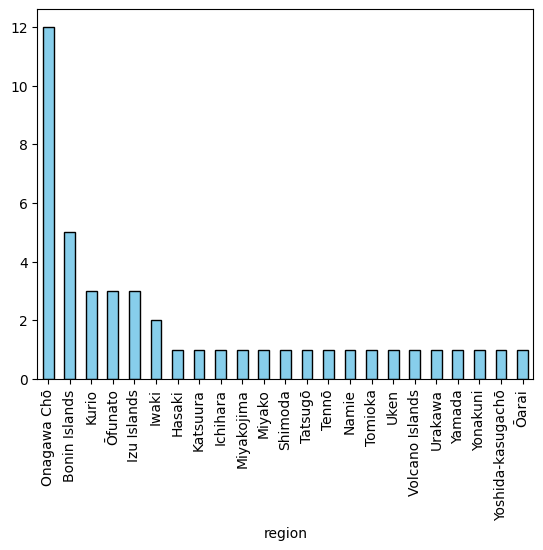

In [23]:
region_counts.plot(kind='bar', color='skyblue', edgecolor='black')


<div dir="rtl" style=" font-size: 20px;">
>>> محاسبه فاصله نقاط زلزله با توکیو
</div>

In [24]:

# tokyo_lat, tokyo_lon = 35.6895, 139.6917

# df['dist_to_tokyo'] = np.sqrt(
#     (df['latitude'] - tokyo_lat)**2 + 
#     (df['longitude'] - tokyo_lon)**2
# )

tokyo_lat, tokyo_lon = 35.6895, 139.6917

lat1 = np.radians(df["latitude"])
lon1 = np.radians(df["longitude"])
lat2 = np.radians(tokyo_lat)
lon2 = np.radians(tokyo_lon)

dlat = lat2 - lat1
dlon = lon2 - lon1

a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
c = 2 * np.arcsin(np.sqrt(a))

df["dist_to_tokyo_km"] = 6371 * c

print(df[["latitude", "longitude", "dist_to_tokyo_km"]].head())


   latitude  longitude  dist_to_tokyo_km
0   30.3762   138.2748        605.373153
1   39.6050   139.5058        435.690933
2   38.5931   142.5944        412.792604
3   30.3456   138.4539        605.300079
4   41.7258   142.6790        719.388080


<div dir="rtl" style=" font-size: 20px;">
>>> محاسبه‌ی شاخص‌های موردنظر با نامپای:</div>

In [ ]:
magnitudes = df["mag"].to_numpy()
distances = df["dist_to_tokyo_km"].to_numpy()

mean_mag = np.mean(magnitudes)
std_mag = np.std(magnitudes)
mean_distance = np.mean(distances)

print("میانگین زلزله ها: ", mean_mag)
print("انحراف معیار: ", std_mag)
print("میانگین فاصله از توکیو: ", mean_distance)

میانگین زلزله ها:  4.595555555555555
انحراف معیار:  0.326568390356824
صدک 90ام:  4.9
میانگین فاصله از توکیو:  620.2861311958952


<div dir="rtl" style=" font-size: 20px;">
>>> خروجی نهایی فایل CSV
</div>

In [26]:
df.to_csv("JAPAN_API_cleaned.csv", index=False)